In [57]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import openpyxl
import pandas as pd
from pathlib import Path
from scipy import stats
from scipy.stats.stats import pearsonr
import seaborn as sns
import statsmodels.api as sm
import sys

import utilities as ut

%matplotlib inline

results_dir = Path("results")
figures_dir = Path("figures")

patient_counts_dir = Path('data/patient_counts')
hm43_counts_dir = Path('data/HM43_counts')
hm56_counts_dir = Path('data/HM56_counts')
hm86_counts_dir = Path('data/HM86_counts')

de_analysis_dir = Path("results/de_results")
gff_dir = Path('private_data/gff_files')

ref_genomes = 'CFT073 536 K-12 UMN026 UTI89'.split()
functional_groups_file = Path('data/genes_and_functions_edited.csv')

# Tables
k_12_genes = pd.read_table("data/All_genes_of_E._coli_K-12.txt", index_col=1)
orth_matrix = pd.read_csv('data/pangenome_analysis/orhtolog_matrix.csv', index_col=0)
print("Number of othrologs: {}".format(orth_matrix.shape[0]))

# Editing
genome_abbr = {'UTI89':'eci', 'K-12':'eco', 'CFT073':'ecc', '536':'ecp', 'UMN026':'eum'}

labels = {"LB":"LB", 
         "UR": "Urine", 
         "UTI": "hUTI",
         "mouse": "mUTI"}

clrs = "#03396c #6497b1 #d3a625 #ae0001 ".split()

Number of othrologs: 10320


## Strain Analysis

#### 1. Get strain pangenome

- Given a matrix of orthologous genes and bacterial strain, generate matrix specific to this strains

In [58]:
def strain_pangenome(pangenome, strain):
    '''Gets gene annotations for a specific strain'''
    panStrain = pangenome[[strain] + ref_genomes].dropna(subset=[strain]).set_index(strain)
    print("Total Number of genes: {}".format(panStrain.shape[0]))
    print('Genes with no reference id: {}'.format(sum(panStrain.isnull().sum(axis=1) == 5)))
    print('Genes with only 1 id: {}'.format(sum(panStrain.isnull().sum(axis=1) == 4)))
    print('Genes with 5 ids: {}'.format(sum(panStrain.isnull().sum(axis=1) == 0)))
    return panStrain

#### 2. Get normalized counts for specific strain

In [59]:
if gff_dir.exists():
    df = pd.DataFrame(ut.normalize_counts_to_tpm(hm43_counts_dir, gff_dir, results_dir))
    df.to_csv(Path(results_dir/"HM43_prokka_tpm.csv"))
    df = pd.DataFrame(ut.normalize_counts_to_tpm(hm56_counts_dir, gff_dir, results_dir))
    df.to_csv(Path(results_dir/"HM56_prokka_tpm.csv"))
    df = pd.DataFrame(ut.normalize_counts_to_tpm(hm86_counts_dir, gff_dir, results_dir))
    df.to_csv(Path(results_dir/"HM86_prokka_tpm.csv"))

In [60]:
def normalize_counts(strain, mouse_counts_dir, gff_dir, results_dir, log=True):
    if gff_dir.exists():
        tpms = ut.normalize_counts_to_tpm(mouse_counts_dir, gff_dir, results_dir) 
        tpm_df = pd.DataFrame(tpms)
        tpm_df.to_csv(Path(results_dir/"{}_prokka_tpm.csv".format(strain)))
    else:
        tpm_df = pd.read_csv(Path(results_dir/"{}_prokka_tpm.csv".format(strain)), index_col=0)
    print('Genes in the genome: {}'.format(tpm_df.shape[0]))
    if log:
        norm_cnts = np.log2(tpm_df+1)
    else:    
        norm_cnts = tpm_df.apply(ut.invnorm)
    if strain == 'HM43':
        norm_cnts['HM43_LB'] = norm_cnts[["HM43_LB_rep1", "HM43_LB_rep2"]].mean(axis=1)
        norm_cnts['HM43_UR'] = norm_cnts[["HM43_UR_rep1", "HM43_UR_rep2"]].mean(axis=1)
        norm_cnts = norm_cnts[[c for c in norm_cnts.columns if 'rep' not in c]]
    return norm_cnts

#### 3. Plot Scatters

In [61]:
def custom_scatter(x, y, data, ax, x_lab='', y_lab='', clr='black', a=0.4, fs=30, size=100):
    ax.scatter(x=x, y=y, data=data, color=clr, alpha=a, s=size)
    if not x_lab:
        x_lab = x
    if not y_lab:
        y_lab = y
    ax.set_xlabel(x_lab, fontsize=fs)
    ax.set_ylabel(y_lab, fontsize=fs)
    ax.set_xticklabels(ax.get_xticks(), fontsize=fs*0.7)
    ax.set_yticklabels(ax.get_yticks(), fontsize=fs*0.7)

    
def scatters(data, filt = ['HM43'], combos = [("LB", "UTI"), ("UR", "UTI"), ("mouse", "UTI")], off=0.1, 
             fs=30, cr=True):
    width = len(filt)
    height = len(combos)
    offset = None
    f, axes = plt.subplots(width, height, figsize=(8*height, 8*width))
    i = 0
    
    for fi in filt:
        df = data[[c for c in data.columns if fi in c and 'rep' not in c]]
        for combo in combos:
            if fi.startswith("HM"):
                x = fi+"_"+combo[0]
                y = fi+"_"+combo[1]
                x_lab = "log2 TPM(" + fi + " | " + labels[combo[0]] + ")"
                y_lab = "log2 TPM(" + fi + " | " + labels[combo[1]] + ")"

            elif combo[0].startswith("HM") and combo[1].startswith("HM"):
                x = combo[0]+"_"+fi
                y = combo[1]+"_"+fi
                x_lab = "log2 TPM(" + combo[0] + " | " + labels[fi] + ")"
                y_lab = "log2 TPM(" + combo[1] + " | " + labels[fi] +  ")"
            else:
                raise KeyError

            custom_scatter(x,y, df, axes[i], x_lab, y_lab, fs=fs)
            if cr:
                r, p_val = stats.pearsonr(df[x], df[y])
                if not offset:
                    offset = df[x].max()*off
                    x_cor = df[x].min()+offset
                    y_cor = df[y].max() - offset
                axes[i].text(x_cor, y_cor, "r = {}\n".format(round(r, 2)), 
                            horizontalalignment='left', fontsize=fs, color='black', weight='semibold')
            i+=1
            
    plt.tight_layout(w_pad=5)
    return f

In [62]:
def strain_analysis(pangenome, strain, counts_dir, gff_dir, out_dir, log=True):
    panStrain = strain_pangenome(pangenome, strain)
    norm_counts = normalize_counts(strain, counts_dir, gff_dir, out_dir, log)
    print(norm_counts.corr())
    f = scatters(norm_counts, filt=[strain],  off=0.1)
    return norm_counts, f

In [63]:
orth_matrix.head()

,536,CFT073,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM66,HM68,HM86,K-12,UMN026,UTI89
77094_rsxE,ECP_RS08045,c2024,PROKKA_01274,PROKKA_04582,PROKKA_00292,PROKKA_01123,PROKKA_01607,PROKKA_05039,PROKKA_04664,PROKKA_03465,PROKKA_03050,PROKKA_00287,PROKKA_01782,PROKKA_00279,PROKKA_00997,PROKKA_03175,b1632,ECUMN_1923,UTI89_C1822
57692_metE_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_05795,NaN,NaN,NaN,NaN,NaN,NaN
78577_ispB,ECP_RS16695,c3945,PROKKA_03042,PROKKA_01605,PROKKA_02164,PROKKA_02956,PROKKA_03284,PROKKA_03241,PROKKA_02954,PROKKA_00194,PROKKA_01329,PROKKA_02168,PROKKA_04883,PROKKA_02050,PROKKA_02664,PROKKA_01316,b3187,ECUMN_3667,UTI89_C3621
77329_yebC,ECP_RS09275,c2278,PROKKA_01526,PROKKA_00189,PROKKA_00534,PROKKA_01401,PROKKA_01856,PROKKA_04790,PROKKA_04413,PROKKA_03714,PROKKA_02810,PROKKA_00530,PROKKA_02057,PROKKA_00523,PROKKA_01238,PROKKA_02912,b1864,ECUMN_2162,UTI89_C2068
76065_fepD,ECP_RS03100,c0677,PROKKA_00084,PROKKA_03548,PROKKA_04266,PROKKA_05060,PROKKA_00472,PROKKA_01159,PROKKA_00950,PROKKA_02341,PROKKA_04092,PROKKA_04279,PROKKA_00306,PROKKA_04088,PROKKA_04797,PROKKA_04323,b0590,ECUMN_0684,UTI89_C0592


Total Number of genes: 3817
Genes with no reference id: 365
Genes with only 1 id: 88
Genes with 5 ids: 2918
Genes in the genome: 4711
            HM43_UTI  HM43_mouse   HM43_LB   HM43_UR
HM43_UTI    1.000000    0.872756  0.812541  0.764574
HM43_mouse  0.872756    1.000000  0.777120  0.749150
HM43_LB     0.812541    0.777120  1.000000  0.846924
HM43_UR     0.764574    0.749150  0.846924  1.000000


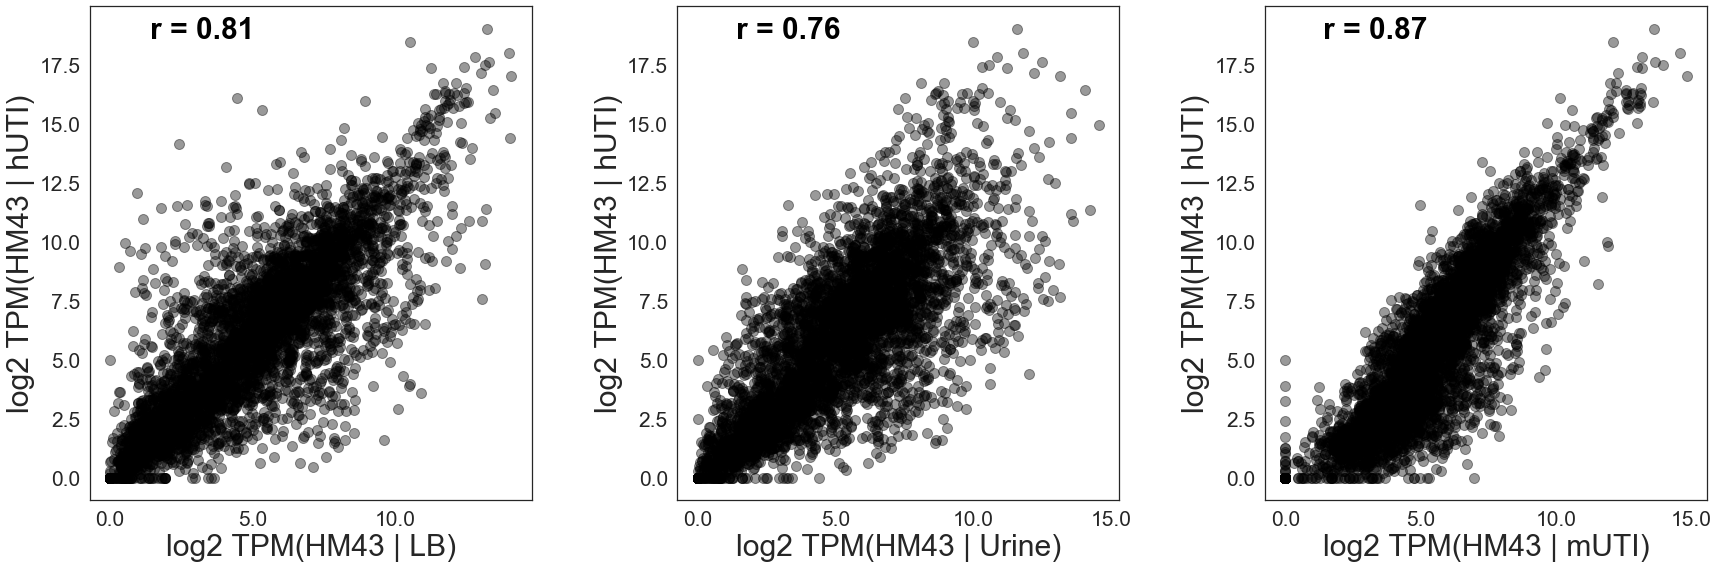

In [64]:
nc43, f = strain_analysis(orth_matrix, "HM43", hm43_counts_dir,gff_dir, results_dir)
f.savefig(figures_dir/"Figure_3a.png", dpi=150, bbox_inches='tight')

Total Number of genes: 3821
Genes with no reference id: 333
Genes with only 1 id: 63
Genes with 5 ids: 2917
Genes in the genome: 4741
            HM56_UTI   HM56_LB   HM56_UR  HM56_mouse
HM56_UTI    1.000000  0.862459  0.732579    0.857765
HM56_LB     0.862459  1.000000  0.806200    0.836290
HM56_UR     0.732579  0.806200  1.000000    0.821368
HM56_mouse  0.857765  0.836290  0.821368    1.000000


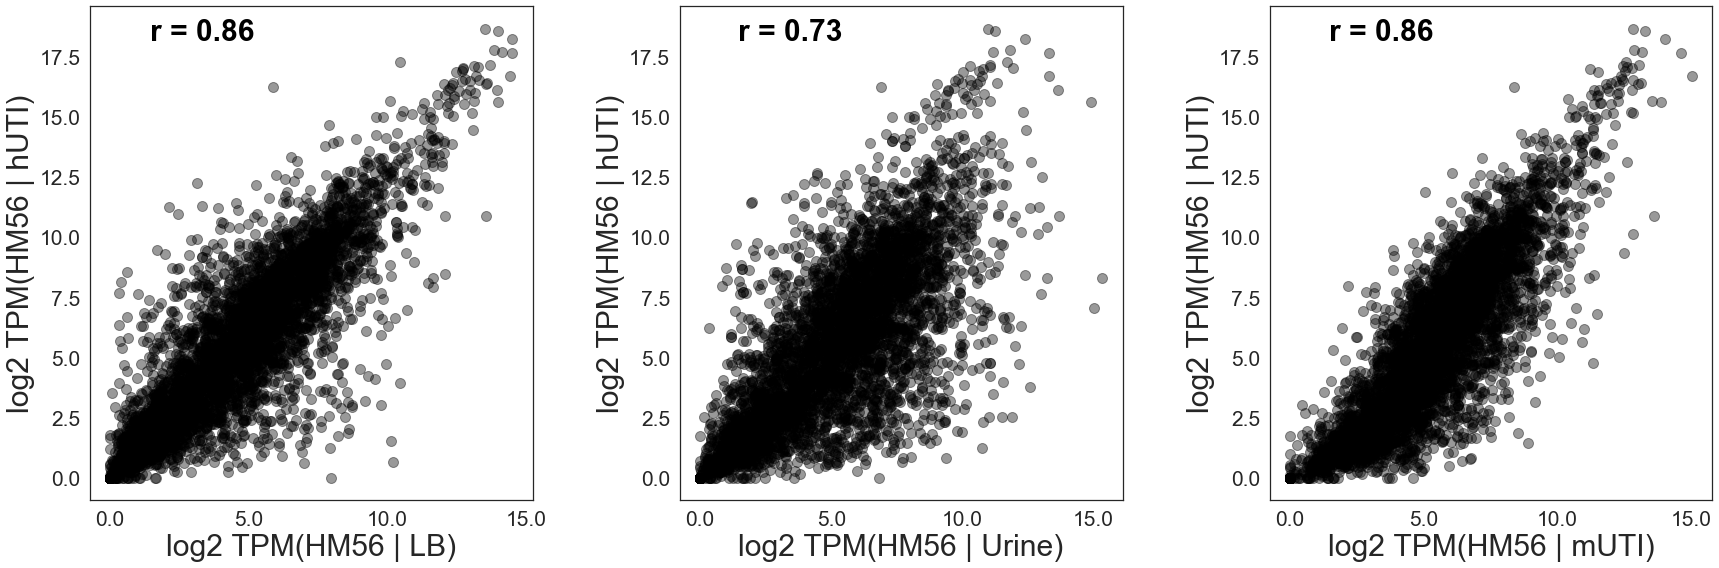

In [65]:
nc56, f = strain_analysis(orth_matrix, "HM56", hm56_counts_dir,gff_dir, results_dir)
f.savefig(figures_dir/"Figure_3b.png", dpi=150, bbox_inches='tight')

Total Number of genes: 3963
Genes with no reference id: 394
Genes with only 1 id: 63
Genes with 5 ids: 2897
Genes in the genome: 5123
             HM86_LB   HM86_UR  HM86_UTI  HM86_mouse
HM86_LB     1.000000  0.824067  0.882717    0.862389
HM86_UR     0.824067  1.000000  0.799306    0.810125
HM86_UTI    0.882717  0.799306  1.000000    0.856091
HM86_mouse  0.862389  0.810125  0.856091    1.000000


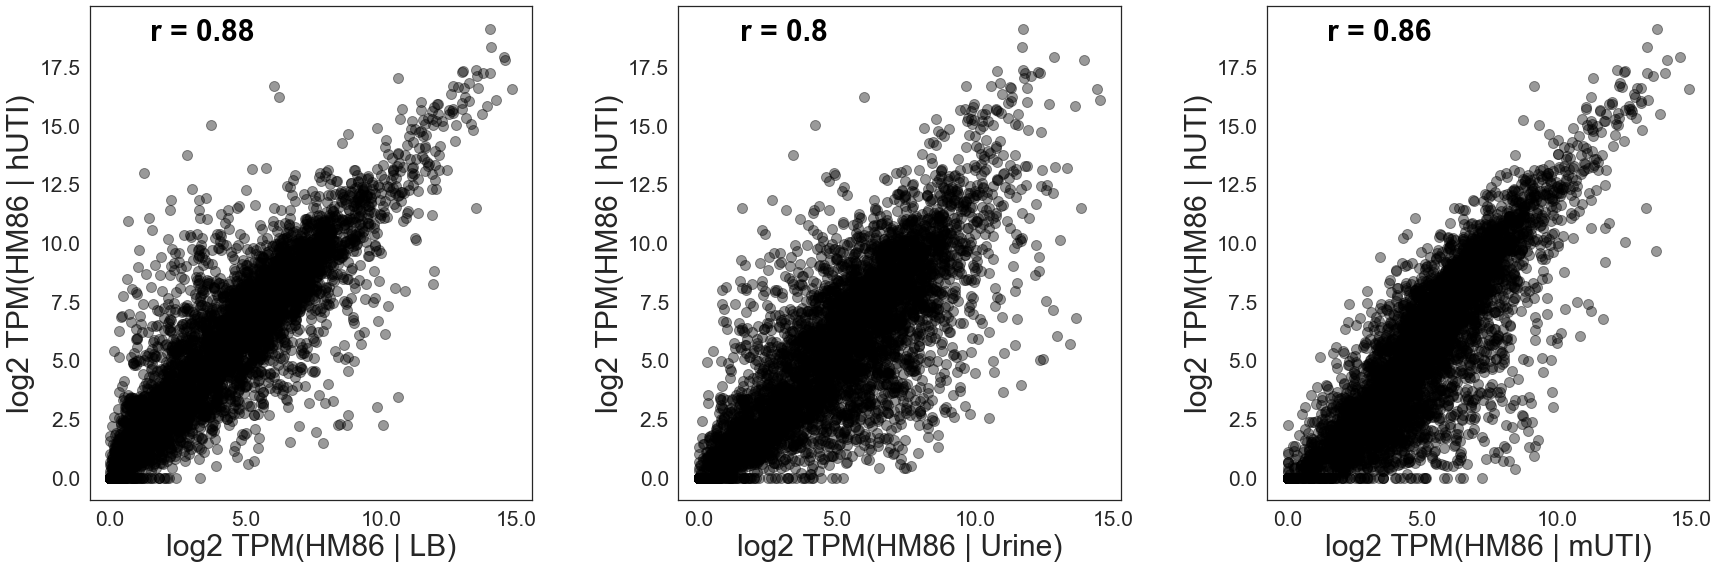

In [66]:
nc86, f = strain_analysis(orth_matrix, "HM86", hm86_counts_dir, gff_dir, results_dir)
f.savefig(figures_dir/"Figure_3c.png", dpi=150, bbox_inches='tight')

## PCA Analysis

In [67]:
norm_cnts1 = (nc43.merge(nc56, how='outer', left_index=True, right_index=True)
             .merge(nc86, how='outer', left_index=True, right_index=True))
norm_cnts = ut.get_tpms_for_prokkas(orth_matrix, norm_cnts1).dropna()

In [68]:
norm_cnts.shape

(3266, 12)

In [69]:
colData = pd.DataFrame([[c.split("_")[0] for c in norm_cnts.columns], 
                        [c.split("_")[1] for c in norm_cnts.columns],
                         [labels[c.split("_")[1]] for c in norm_cnts.columns]], columns = norm_cnts.columns,
                         index = ["strain", 'treat', 'treat_label']).T

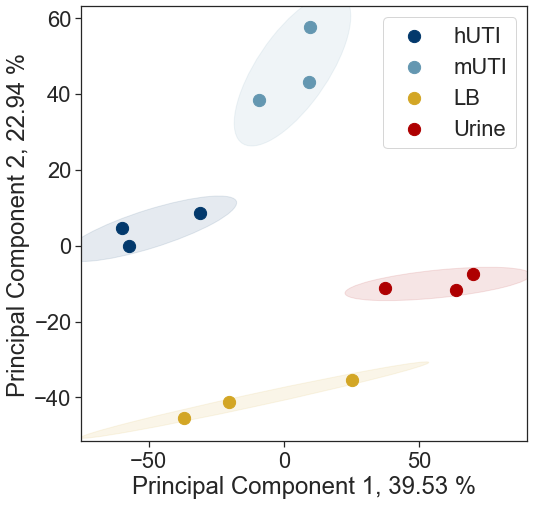

In [70]:
pDf, pc1, pc2 = ut.find_pc1_pc2(norm_cnts, colData)
f = ut.plotPCA(pDf, pc1, pc2, "treat_label", col=clrs, nameby="", el=True)
ax = f.gca()
ax.set_xlim((-75, 90))
f.savefig(figures_dir/"Figure_4a.png", dpi = 150, bbox_inches="tight")

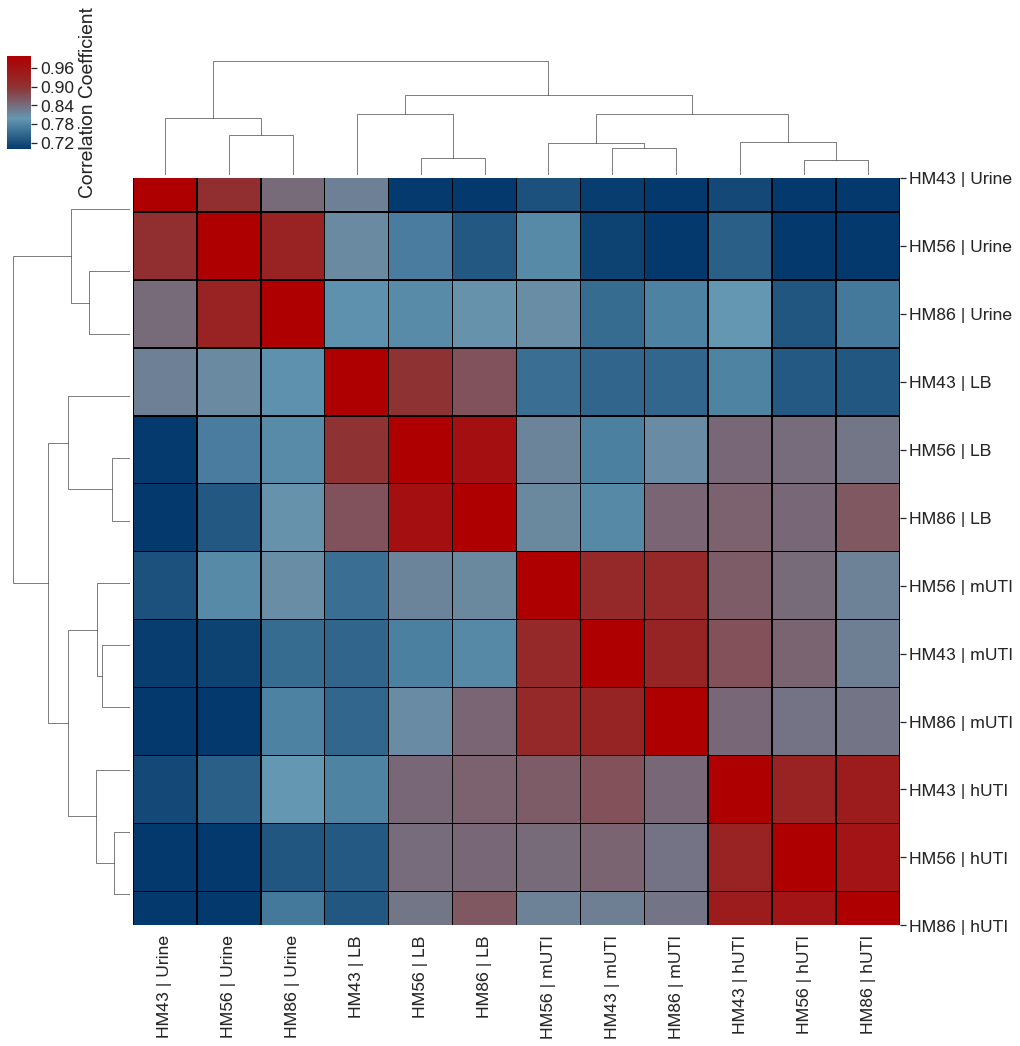

In [71]:
cmap_clrs = "#03396c #6497b1 #8f3233 #ae0001".split()
sns.set_style("white")
sns.set_context("notebook", font_scale=1.6)
my_cmap = LinearSegmentedColormap.from_list('custom blue', cmap_clrs, N=256)

correlation_df = norm_cnts.corr()
correlation_df.columns = [c.split("_")[0]+" | "+labels[c.split("_")[1]] for c in correlation_df.columns]
correlation_df.index = [c.split("_")[0]+" | "+labels[c.split("_")[1]] for c in correlation_df.index]

g = sns.clustermap(correlation_df, cmap=my_cmap,linewidths=0.5, linecolor='black',figsize=(16,16),vmin=0.7, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'})
g.savefig(figures_dir/"Figure_4b_colorbar.png", dpi = 150, bbox_inches="tight")

In [72]:
urine = [x for x in norm_cnts.columns if 'UR' in x]
lb = [x for x in norm_cnts.columns if 'LB' in x]
mou = [x for x in norm_cnts.columns if 'mouse' in x]
pat = [x for x in norm_cnts.columns if 'UTI' in x]
Ucor = norm_cnts.corr().loc[urine][pat]
Umean = Ucor.values.mean()
Lcor = norm_cnts.corr().loc[lb][pat]
Lmean = Lcor.values.mean()
Mcor = norm_cnts.corr().loc[mou][pat]
Mmean = Mcor.values.mean()

print(Umean)
print(Lmean)
print(Mmean)

Ucor.values.mean()

0.7056450775889662
0.8146708237672432
0.8426973803392386


0.7056450775889662

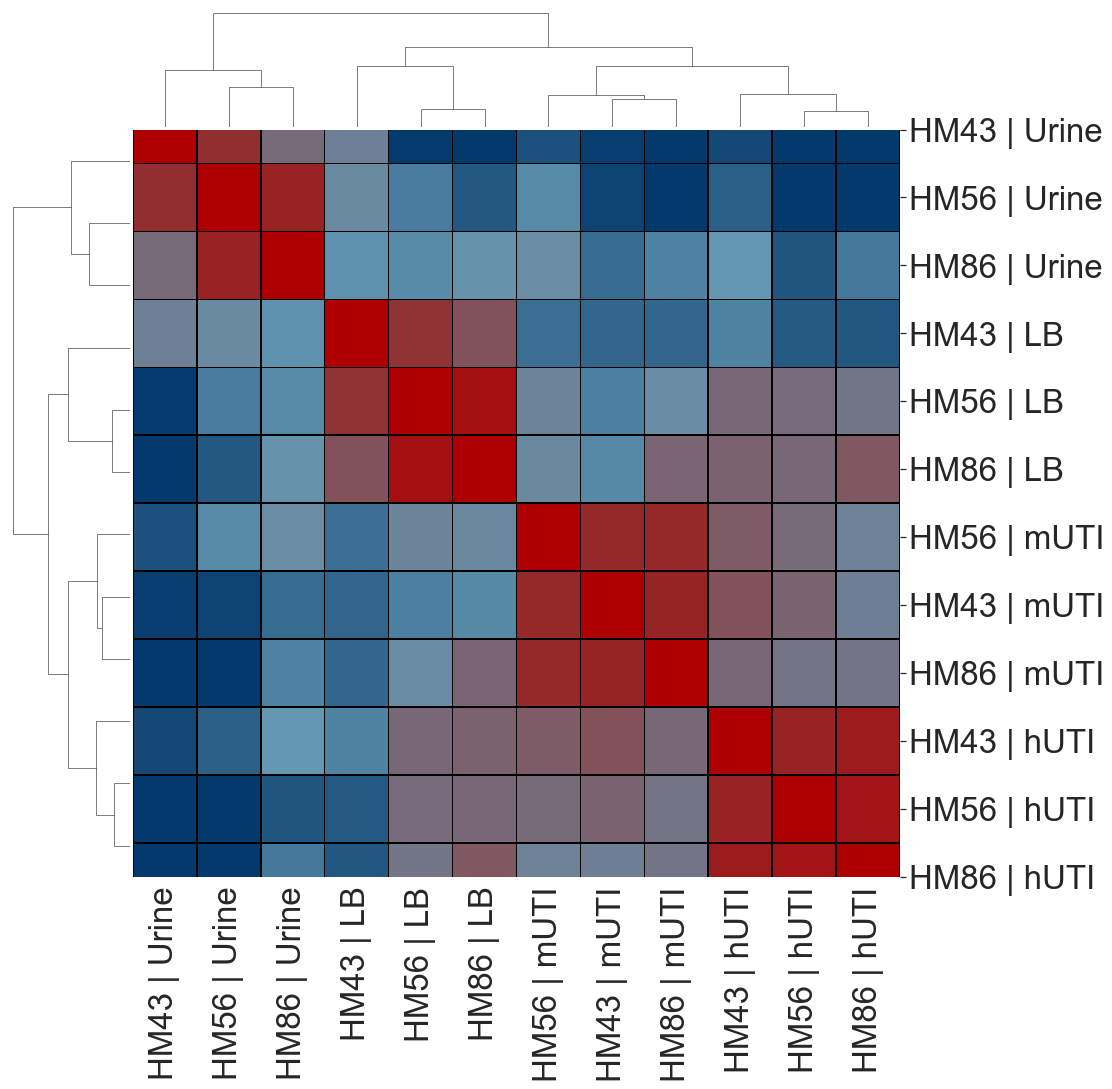

In [73]:
sns.set_context("notebook", font_scale=3)
g = sns.clustermap(correlation_df, cmap=my_cmap,linewidths=0.5, linecolor='black',figsize=(16,16),vmin=0.7, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'})
g.cax.set_visible(False)
g.savefig(figures_dir/"Figure_4b_no_colorbar.png")

## Differential Expression Analysis

In [74]:
uti_mouse = pd.read_csv(de_analysis_dir/"PATIENT_vs_MOUSE_all_genes_edited.csv", index_col=0)
uti_lb = pd.read_csv(de_analysis_dir/"PATIENT_vs_LB_all_genes_edited.csv", index_col=0)
uti_ur = pd.read_csv(de_analysis_dir/'PATIENT_vs_URINE_all_genes_edited.csv', index_col=0)
mouse_lb = pd.read_csv(de_analysis_dir/'MOUSE_vs_LB_all_genes_edited.csv', index_col=0)
mouse_ur = pd.read_csv(de_analysis_dir/'MOUSE_vs_URINE_all_genes_edited.csv', index_col=0)
uti_mouse.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Genome,Gene_ID,Name,Description
77094_rsxE,2313.192929,1.446403,0.635486,0.70246,0.482392,1.0,K-12,b1632,rsxE,SoxR [2Fe-2S] reducing system protein RsxE
78577_ispB,3214.863421,0.575223,0.238292,0.00000,1.000000,1.0,K-12,b3187,ispB,all-trans-octaprenyl-diphosphate synthase
77329_yebC,14889.531974,0.654174,0.390623,0.00000,1.000000,1.0,K-12,b1864,yebC,putative transcriptional regulator YebC
76065_fepD,357.185607,0.674847,0.415054,0.00000,1.000000,1.0,K-12,b0590,fepD,ferric enterobactin ABC transporter membrane s...
77731_alaA,5933.112898,0.771903,0.425008,0.00000,1.000000,1.0,K-12,b2290,alaA,glutamate--pyruvate aminotransferase AlaA


In [75]:
de_results = uti_mouse
de_up = de_results[(de_results.log2FoldChange >= 1)& (de_results.padj < 0.05)]
de_down = de_results[(de_results.log2FoldChange <= -1)& (de_results.padj < 0.05)]
print("Down: ", de_down.shape[0]) # 146
print("Up: ", de_up.shape[0]) # 33

Down:  146
Up:  33


In [76]:
go_results = (pd.read_csv("results/pathway_analysis/PATIENT_MOUSE_pathway_analysis_BP.csv", index_col=0)
             .sort_values(by=["Annotated"], ascending=False))
go_results

,GO.ID,Annotated,Significant,Expected,elimFisher,Term,genesInTerm,DEGenesInTerm
28,GO:0015711,96,13,5.45,0.02985,organic anion transport,"aaeA,aaeB,acrA,actP,adiC,alaE,ansP,argO,artJ,a...","dcuB,dcuC,dsdX,exuT,lysP,potE,tdcC,uacT,uhpT,u..."
21,GO:0015849,74,12,4.20,0.01455,organic acid transport,"aaeA,aaeB,acrA,actP,adiC,alaE,ansP,argO,artJ,a...","dcuB,dcuC,dsdX,exuT,lysP,potE,tdcC,uacT,ulaA,u..."
34,GO:0046942,73,11,4.15,0.03659,carboxylic acid transport,"aaeA,aaeB,acrA,actP,adiC,alaE,ansP,argO,artJ,a...","dcuB,dcuC,dsdX,exuT,lysP,potE,tdcC,ulaA,ulaB,u..."
43,GO:1903825,51,9,2.90,0.04620,organic acid transmembrane transport,"actP,adiC,alaE,ansP,argO,artM,brnQ,cycA,cydC,c...","dsdX,exuT,lysP,potE,uacT,ulaA,ulaB,ulaC,yifK"
32,GO:0006928,43,6,2.44,0.03201,movement of cell or subcellular component,"cdgI,chaC,cheY,cheZ,dgcF,dgcJ,dgcN,dgcZ,ecpR,f...","fdrA,frdA,frdB,frdC,glgS,preA"
7,GO:0072329,42,8,2.39,0.00197,monocarboxylic acid catabolic process,"acnB,acs,aidB,ansA,caiA,dgoD,dgoK,fadA,fadB,fa...","caiA,fadH,fixB,glxR,gntK,lgoD,uxaA,uxaC"
31,GO:0071973,32,5,1.82,0.03182,bacterial-type flagellum-dependent cell motility,"cdgI,chaC,cheY,cheZ,dgcF,dgcJ,dgcN,ecpR,fdrA,f...","fdrA,frdA,frdB,frdC,glgS"
30,GO:0097588,32,5,1.82,0.03182,archaeal or bacterial-type flagellum-dependent...,"cdgI,chaC,cheY,cheZ,dgcF,dgcJ,dgcN,ecpR,fdrA,f...","fdrA,frdA,frdB,frdC,glgS"
29,GO:0001539,32,5,1.82,0.03182,cilium or flagellum-dependent cell motility,"cdgI,chaC,cheY,cheZ,dgcF,dgcJ,dgcN,ecpR,fdrA,f...","fdrA,frdA,frdB,frdC,glgS"
45,GO:0044242,15,3,0.85,0.04924,cellular lipid catabolic process,"acnB,aidB,caiA,cdh,fadA,fadB,fadE,fadH,fadM,fi...","caiA,fadH,fixB"


In [77]:
all_transport_genes = go_results[go_results.Term.str.contains('transport')].DEGenesInTerm.values
inter = [f.split(',') for f in all_transport_genes ]
final = set([x for f in inter for x in f])
de_transport = de_results[de_results.Name.isin(final)]

In [78]:
all_transport_genes = go_results[go_results.Term.str.contains('catabolic')].DEGenesInTerm.values
inter = [f.split(',') for f in all_transport_genes ]
final = set([x for f in inter for x in f])
de_catabolic = de_results[de_results.Name.isin(final)]

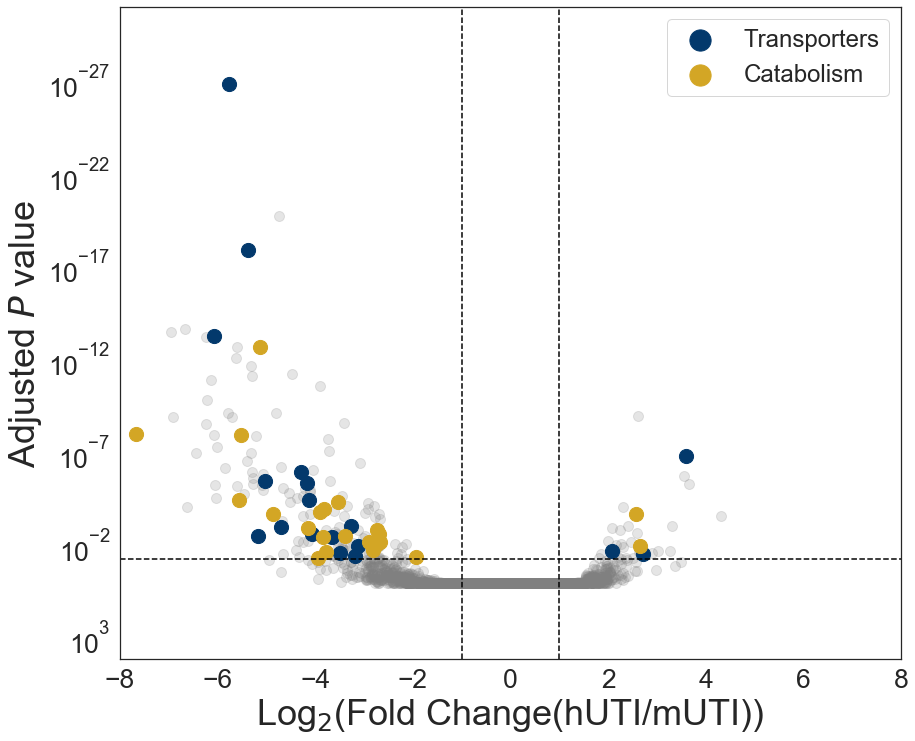

In [79]:
# Drawing the volcano plot


sns.set_context("notebook", font_scale=2.4)
fig = plt.figure(figsize=(14,12))
plt.yscale('log')
plt.xlim(-8, 8)
plt.rcParams["lines.markersize"] = 10.0
plt.scatter(de_results.log2FoldChange, de_results.padj, color='grey', s=100,alpha=0.2, label=None)
plt.scatter(de_transport.log2FoldChange, de_transport.padj, color=clrs[0], s=200,label="Transporters")
plt.scatter(de_catabolic.log2FoldChange, de_catabolic.padj, color=clrs[2], s=200, label='Catabolism')
# for i, txt in enumerate(de_transport.Name):
#     x = de_transport.log2FoldChange
#     y = de_transport.padj
#     plt.gca().annotate(txt, (x[i], y[i]), xytext=(x[i]+0.15, y[i]), fontsize=16)

# #plt.scatter(de_catabolic.log2FoldChange, de_catabolic.padj, color="#74d600", s=200,  label="Catabolic Process")
# plt.scatter(sugar_aa_met_df.log2FoldChange, sugar_aa_met_df.padj, color=col5, 
#             label="Sugar Catabolism/Amino Acid Biosynthesis")
# plt.scatter(sugar_tt_df.log2FoldChange, sugar_tt_df.padj, color="#00ced1",  label="Sugar Transporters")



plt.axvline(-1, color='k', linestyle="--",)
plt.axvline(1, color='k', linestyle="--")
plt.axhline(0.05, color='k', linestyle="--")
plt.xlabel("Log$_2$(Fold Change(hUTI/mUTI))", fontsize=36)
plt.ylabel("Adjusted $\itP$ value", fontsize=36)
plt.gca().invert_yaxis()

plt.legend(markerscale=1.5, frameon=True, facecolor="white", framealpha=0.8, fontsize=24)

fig.savefig(figures_dir/"Figure_5a.png", dpi=150, bbox_inches="tight")


In [80]:
mouse_lb_short = (mouse_lb[["log2FoldChange", "Gene_ID", "Name", "padj"]]
                  .rename({"log2FoldChange": "log2FC_mouse", "padj":"padj_mouse"}, axis=1))
uti_lb_short = (uti_lb[["log2FoldChange", "padj"]].
               rename({"log2FoldChange": "log2FC_uti", "padj":"padj_uti"}, axis=1))
mouse_uti_lb = uti_lb_short.merge(mouse_lb_short, right_index=True, left_index=True)
mouse_uti_lb= mouse_uti_lb[(mouse_uti_lb.padj_mouse < 0.05) & (mouse_uti_lb.padj_uti < 0.05)]
mouse_uti_lb_up = mouse_uti_lb[(mouse_uti_lb.log2FC_uti > 1) & (mouse_uti_lb.log2FC_mouse > 1)]
mouse_uti_lb_down = mouse_uti_lb[(mouse_uti_lb.log2FC_uti < -1) & (mouse_uti_lb.log2FC_mouse < -1)]

In [81]:
mouse_uti_lb_down.to_excel(results_dir/"HOST_DOWN_VS_LB.xlsx")
mouse_uti_lb_up.to_excel(results_dir/"HOST_UP_VS_LB.xlsx")

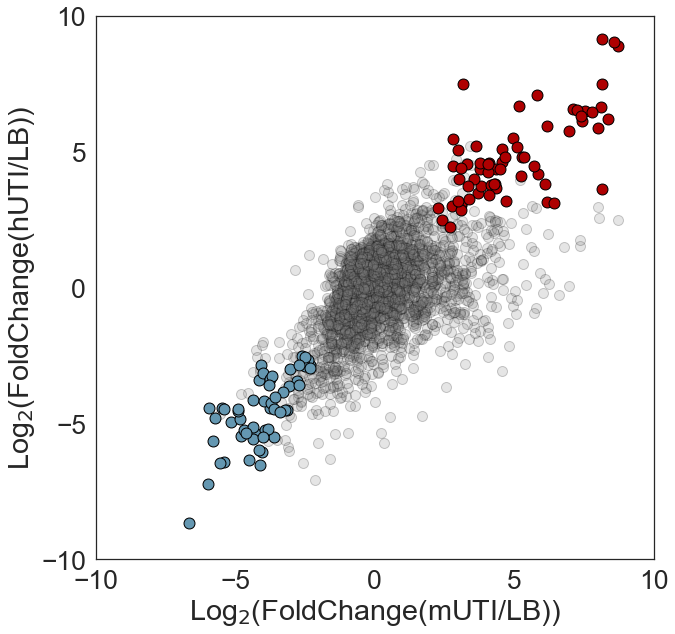

In [82]:
sns.set_context("notebook", font_scale=2.4)
sns.set_style('white')
f = plt.figure(figsize=(10,10))
plt.scatter(mouse_lb.log2FoldChange, uti_lb.log2FoldChange, color='grey', s=100, edgecolors='black',alpha=0.2 )
plt.scatter(mouse_uti_lb_up.log2FC_mouse, mouse_uti_lb_up.log2FC_uti, color=clrs[3], 
            edgecolors='black',s=120)
plt.scatter(mouse_uti_lb_down.log2FC_mouse, mouse_uti_lb_down.log2FC_uti, color=clrs[1], 
            edgecolors='black',s=120)
plt.xlabel("Log$_2$(FoldChange(mUTI/LB))")
plt.ylabel("Log$_2$(FoldChange(hUTI/LB))")

plt.locator_params(nbins=5)
plt.ylim(-10,10)
plt.xlim(-10,10)
f.savefig(figures_dir/"Figure_5b.png", dpi=150, bbox_inches="tight")

In [83]:
mouse_ur_short = (mouse_ur[["log2FoldChange", "Gene_ID", "Name", "padj"]]
                  .rename({"log2FoldChange": "log2FC_mouse", "padj":"padj_mouse"}, axis=1))
uti_ur_short = (uti_ur[["log2FoldChange", "padj"]].
               rename({"log2FoldChange": "log2FC_uti", "padj":"padj_uti"}, axis=1))
mouse_uti_ur = uti_ur_short.merge(mouse_ur_short, right_index=True, left_index=True)
mouse_uti_ur= mouse_uti_ur[(mouse_uti_ur.padj_mouse < 0.05) & (mouse_uti_ur.padj_uti < 0.05)]
mouse_uti_ur_up = mouse_uti_ur[(mouse_uti_ur.log2FC_uti > 1) & (mouse_uti_ur.log2FC_mouse > 1)]
mouse_uti_ur_down = mouse_uti_ur[(mouse_uti_ur.log2FC_uti < -1) & (mouse_uti_ur.log2FC_mouse < -1)]

In [84]:
mouse_uti_ur_down.to_excel(results_dir/"HOST_DOWN_VS_URINE.xlsx")
mouse_uti_ur_up.to_excel(results_dir/"HOST_UP_VS_URINE.xlsx")

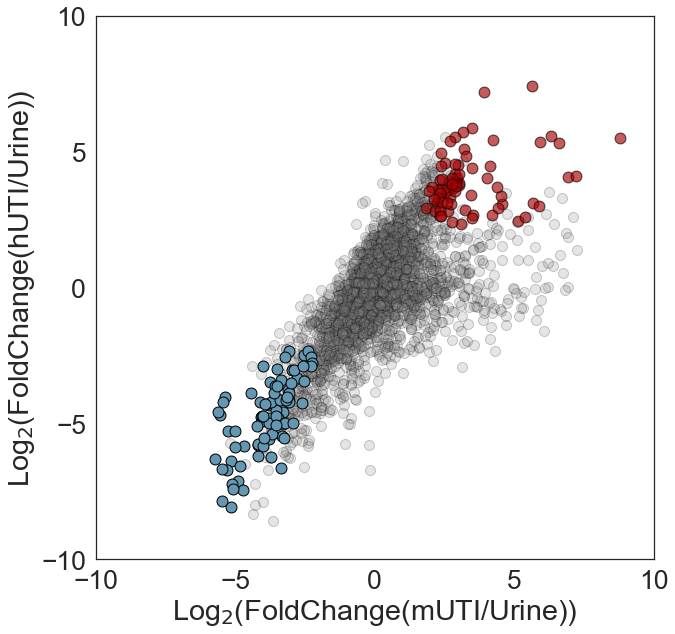

In [85]:
sns.set_context("notebook", font_scale=2.4)
sns.set_style('white')
f = plt.figure(figsize=(10,10))
plt.scatter(mouse_ur.log2FoldChange, uti_ur.log2FoldChange, color='grey', s=100, edgecolors='black',alpha=0.2 )
plt.scatter(mouse_uti_ur_up.log2FC_mouse, mouse_uti_ur_up.log2FC_uti, color=clrs[3], 
            edgecolors='black',s=120, alpha=0.6)
plt.scatter(mouse_uti_ur_down.log2FC_mouse, mouse_uti_ur_down.log2FC_uti, color=clrs[1], 
            edgecolors='black',s=120)
plt.xlabel("Log$_2$(FoldChange(mUTI/Urine))")
plt.ylabel("Log$_2$(FoldChange(hUTI/Urine))")
plt.locator_params(nbins=5)
plt.ylim(-10,10)
plt.xlim(-10,10)
f.savefig(figures_dir/"Figure_5c.png", dpi=150, bbox_inches="tight")

## Functional groups

In [86]:
from Bio.KEGG import REST

paths = ["path:eco00561 ", "path:eco00564"]

def get_genes_for_pathway(pathway):
    genes = []
    pathway_file = REST.kegg_get(pathway).read()
    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section

        if current_section == "GENE":
            gene_identifiers = line[12:].split("; ")[0]
            gene_id, gene_symbol = gene_identifiers.split()
            if not gene_symbol in genes:
                genes.append(gene_id)
    return genes


In [87]:
fgroups = pd.read_csv(functional_groups_file, index_col=0) 
to_keep = ['Functional Group', "Description", "Gene_ID"]
fgroups = fgroups[to_keep]


In [88]:
fun_orth = pd.read_csv("data/2019-06-09_virulence_orthologs.csv", index_col=0).dropna(how='all')
fun_orth.index = [i.split("|")[0] for i in fun_orth.index]
fun_orth = fun_orth[["HM43", "HM56", "HM86"]]
fun_cnts = ut.get_tpms_for_prokkas(fun_orth, norm_cnts1)
fun_cnts = fun_cnts.merge(fgroups, left_index=True, right_on="Gene_ID")
fun_cnts.shape

(250, 15)

In [104]:
 def plot_functional_group(df, group_alias, groupby="Description",
                          conditions = [("HM43_LB", "HM43_UTI"), ("HM43_UR", "HM43_UTI"), 
                                        ("HM43_mouse", "HM43_UTI")]):
   
    m_list = ['o', 'v', 's','*', 'p', 'h', '+', 8, '>', 'x']
    c_list = ["#44bec7", "#ffc300",  "#234d20","#d696bb", "#fa3c4c", "#0084ff",
             "#36802d", "#c9df8a", "#673888", "orange"]
    #from matplotlib import rc
    #rc('text', usetex=True)
    label_dict = {'tonB': '$\it{tonB}$',
                 'Sit Operon': '$\it{sit}$',
                 'Fhu Operon': '$\it{fhu}$',
                 'auf':'$\it{auf}$', 
                 'fim': '$\it{fim}$',
                 'pap': '$\it{pap}$',
                 'yad': '$\it{yad}$',
                 'yeh': '$\it{yeh}$',
                 'yfc': '$\it{yfc}$',
                 'sfa': '$\it{sfa}$'}
    for t in conditions:
        k=0
        fig = plt.figure(figsize=(8,8))
        
        for i, g in df.groupby(groupby):
            if i in label_dict.keys():
                l = label_dict[i]
            else:
                l = i
            plt.scatter(x=t[0], y=t[1], data=g, marker=m_list[k], color= c_list[k],
                        s=200,label=l)
            k+=1
            plt.legend(fontsize=24, bbox_to_anchor=(1.2, 1))

            #plt.scatter( x = t[0], y =t[1], data=iron_df, color = 'black');
        x_lab = t[0].split("_")
        y_lab = t[1].split("_")
        plt.xlabel("log$_2$TPM({}|{})".format(x_lab[0], labels[x_lab[1]]), fontsize=24)
        plt.ylabel("log$_2$TPM({}|{})".format(y_lab[0], labels[y_lab[1]]),fontsize=24)
        plt.plot([-1, 14], [-1, 14], 'k-')
        plt.locator_params(nbins=8)
        plt.xlim(-1, 14)
        plt.ylim(-1, 14)
        fig.savefig(figures_dir/"Figure_6_{}_{}.png".format(group_alias, t[0]),
                    dpi=150, bbox_inches='tight')

In [105]:
fgroups

,Functional Group,Description,Gene_ID
co,,,
fepA,Iron Acquisition,Enterobactin,c0669
iha,Iron Acquisition,Enterobactin,c3610
ireA,Iron Acquisition,Enterobactin,c5174
fiu,Iron Acquisition,Enterobactin,c0890
cirA,Iron Acquisition,Enterobactin,c2690
...,...,...,...
acnA,metabolism,TCA cycle,c1745
acnB,metabolism,TCA cycle,c0147
gltA,metabolism,TCA cycle,c0796


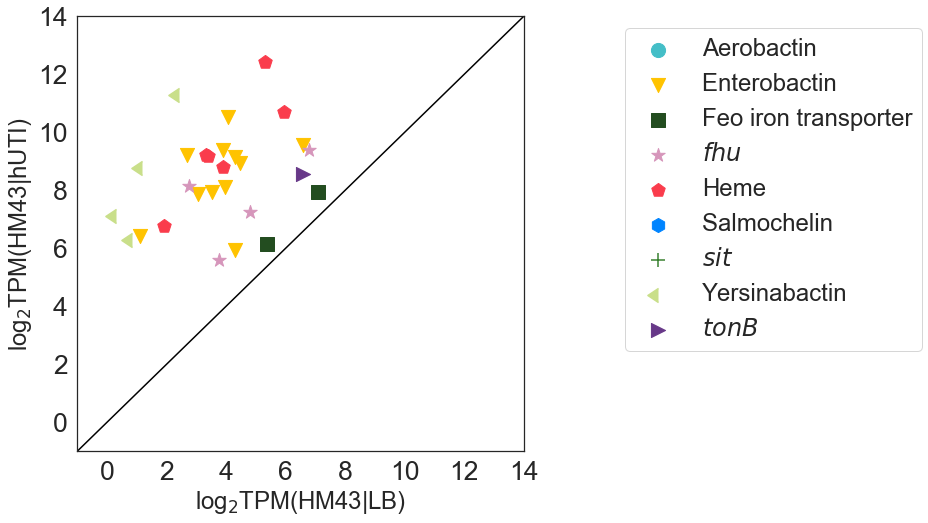

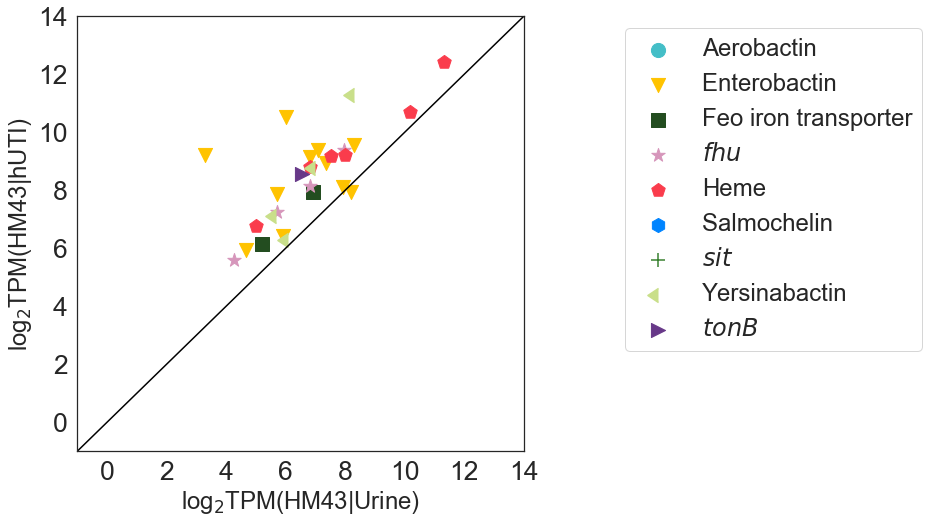

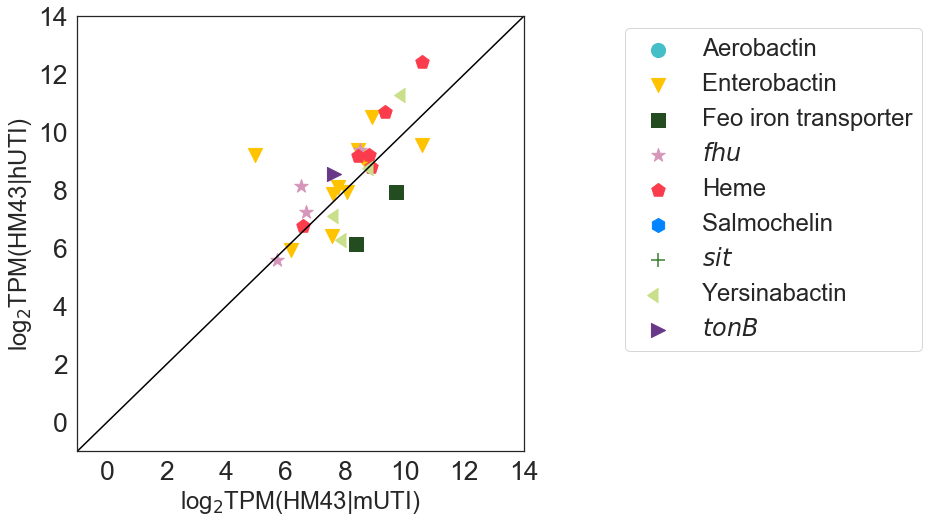

In [106]:
df = fun_cnts[fun_cnts["Functional Group"] == "Iron Acquisition"]
plot_functional_group(df,  'iron')

In [107]:
cond2 = [("HM56_LB", "HM56_UTI"), ("HM56_UR", "HM56_UTI"), ("HM56_mouse", "HM56_UTI")]
cond3 = [("HM86_LB", "HM86_UTI"), ("HM86_UR", "HM86_UTI"), ("HM86_mouse", "HM86_UTI")]

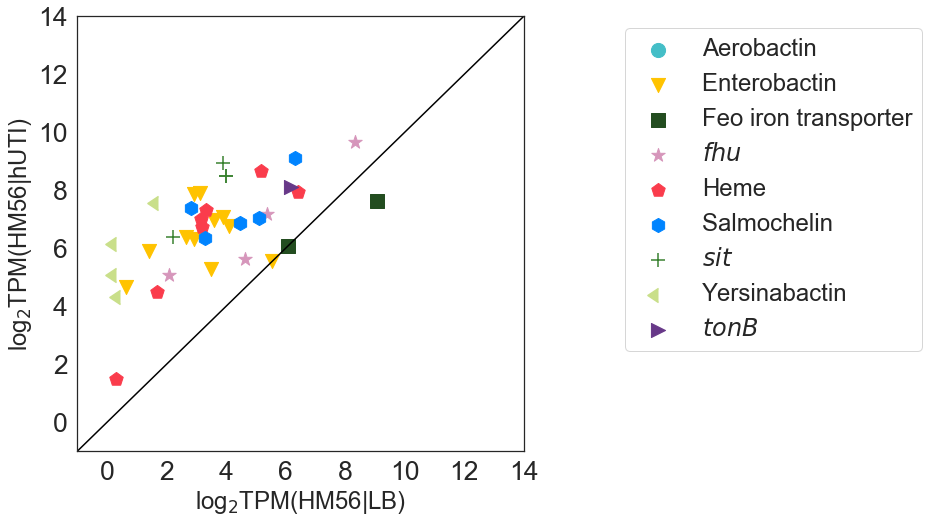

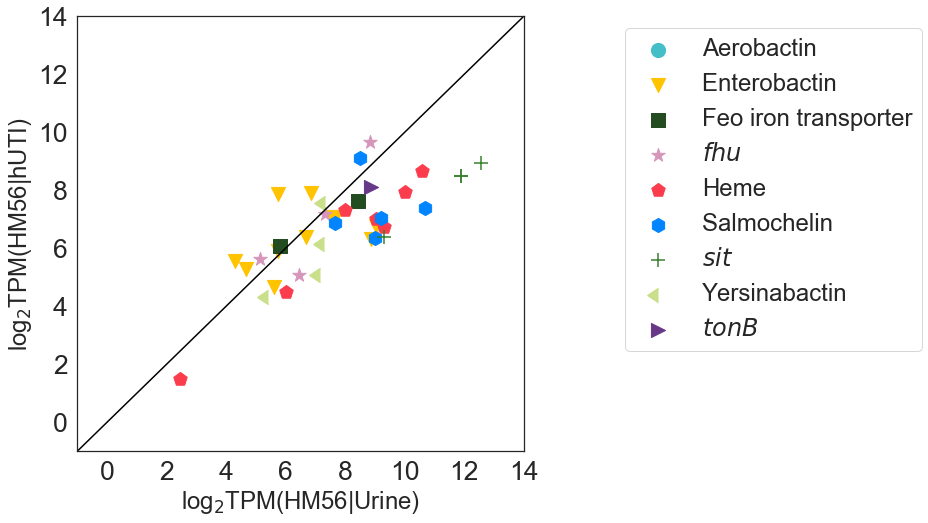

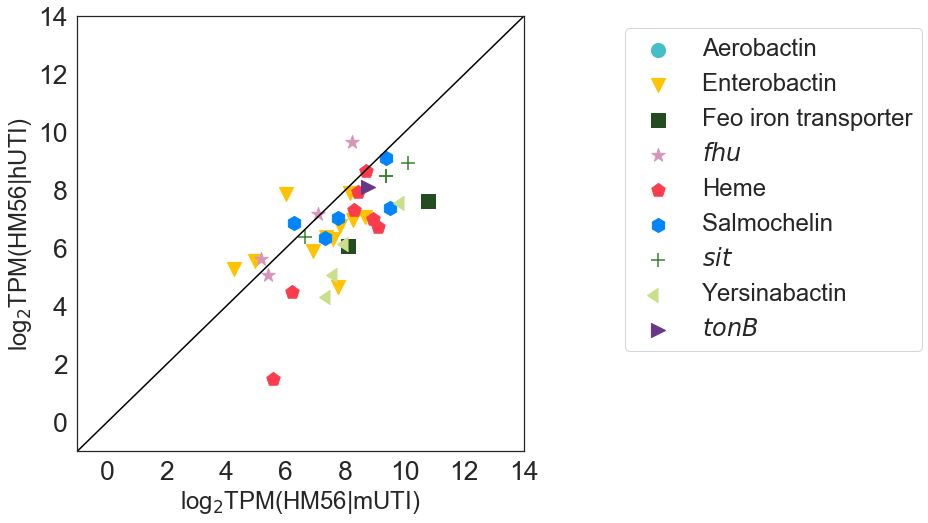

In [108]:
plot_functional_group(df,  group_alias='iron', conditions=cond2)

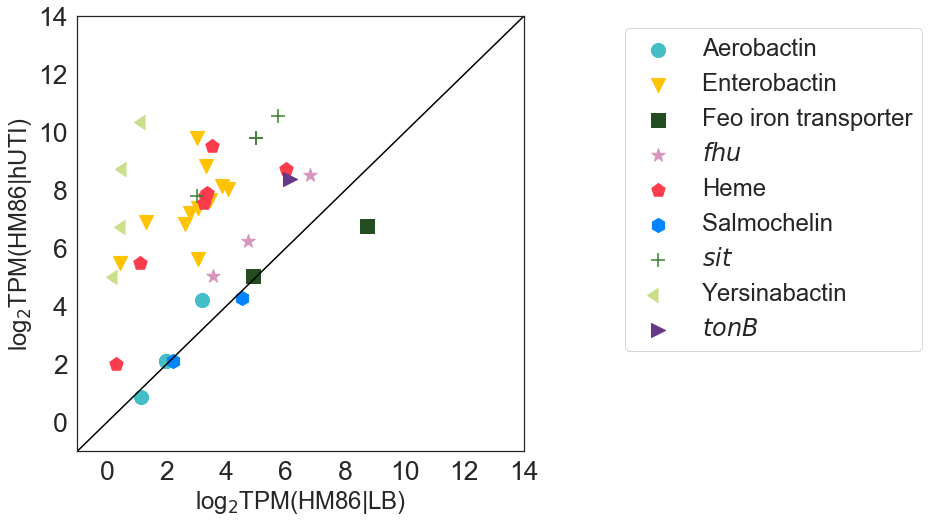

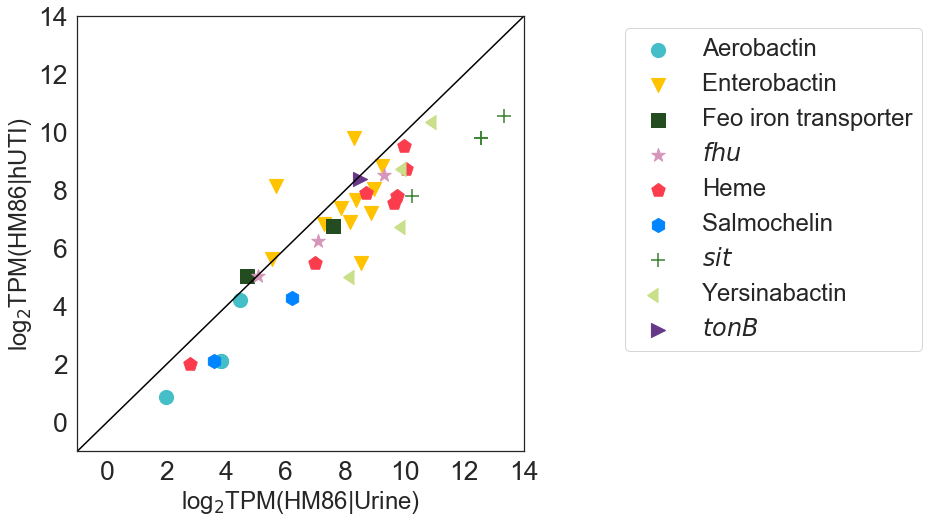

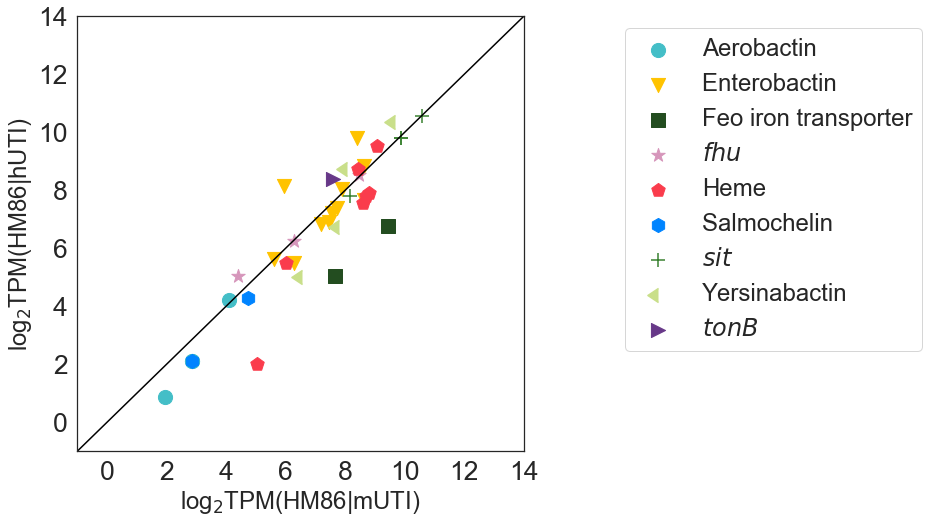

In [109]:
plot_functional_group(df,  'iron', conditions=cond3)

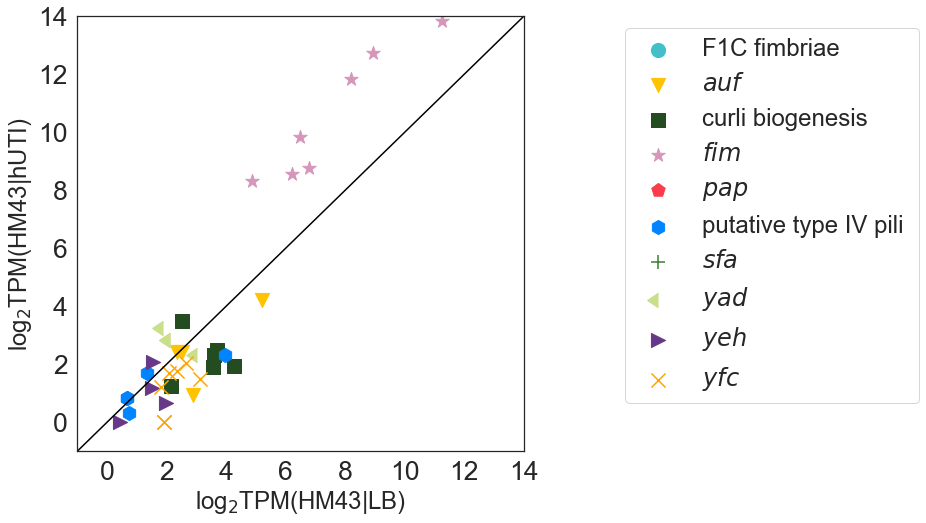

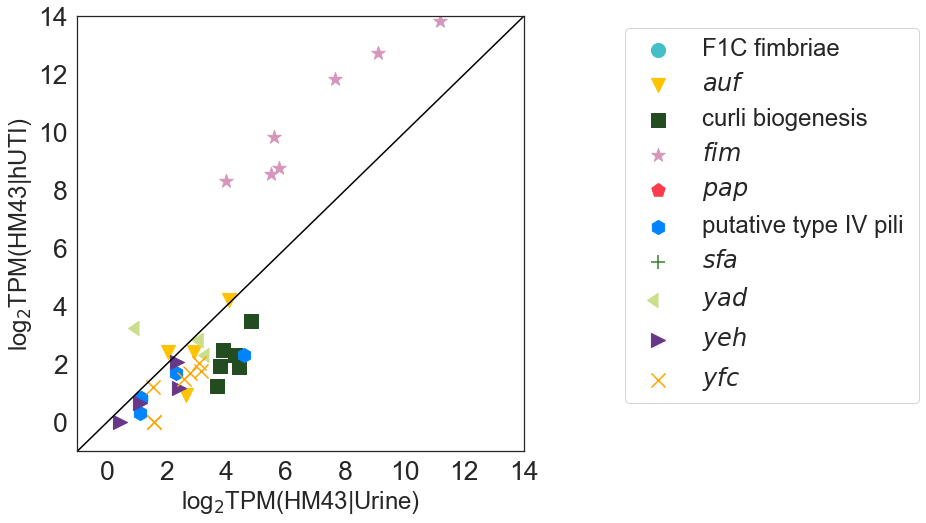

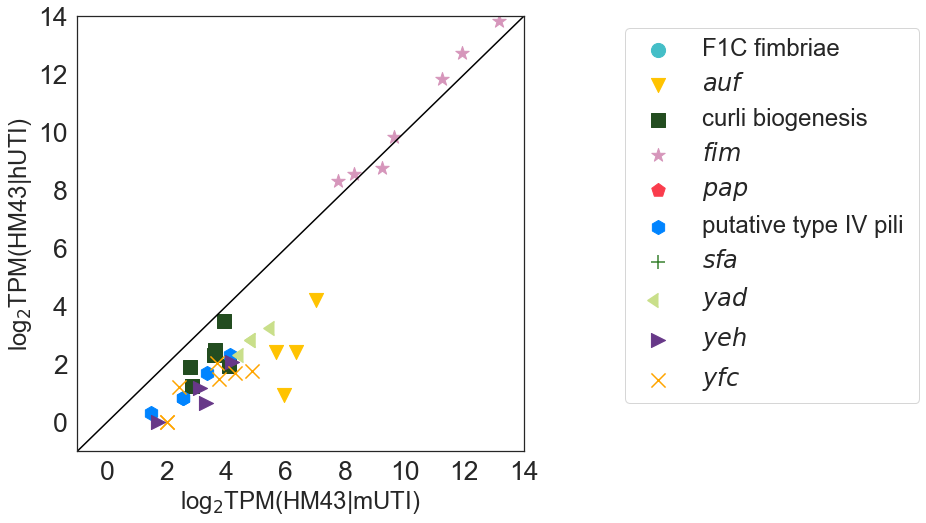

In [110]:
df = fun_cnts[fun_cnts["Functional Group"] == "adherence"]
plot_functional_group(df, 'adhesins')

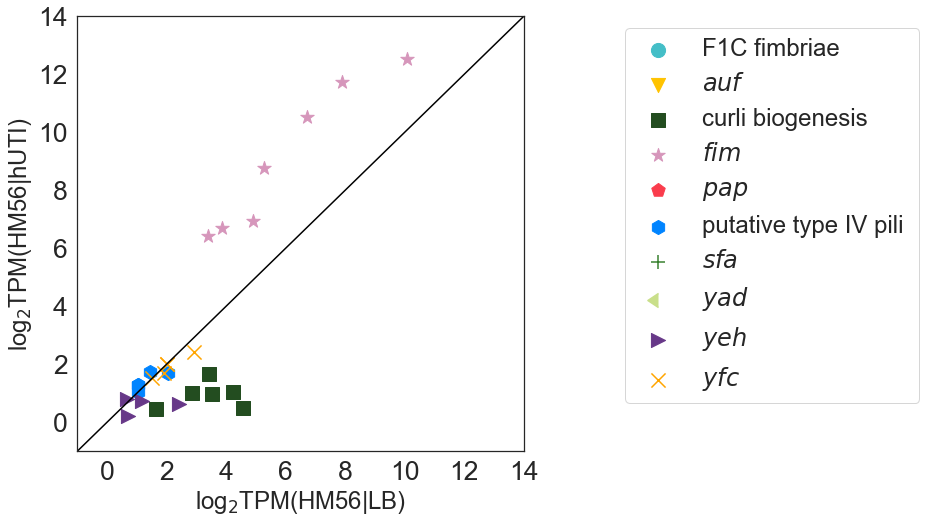

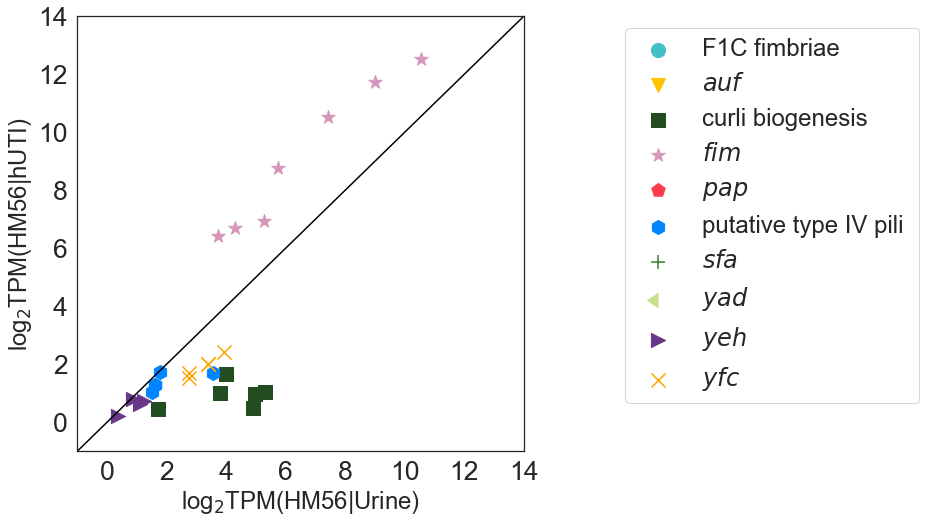

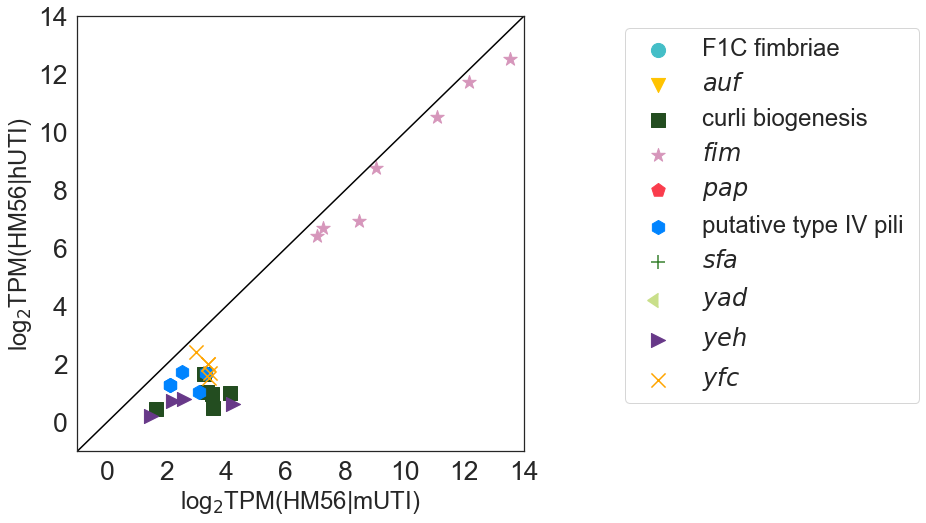

In [111]:
plot_functional_group(df,  group_alias='adherence', conditions=cond2)

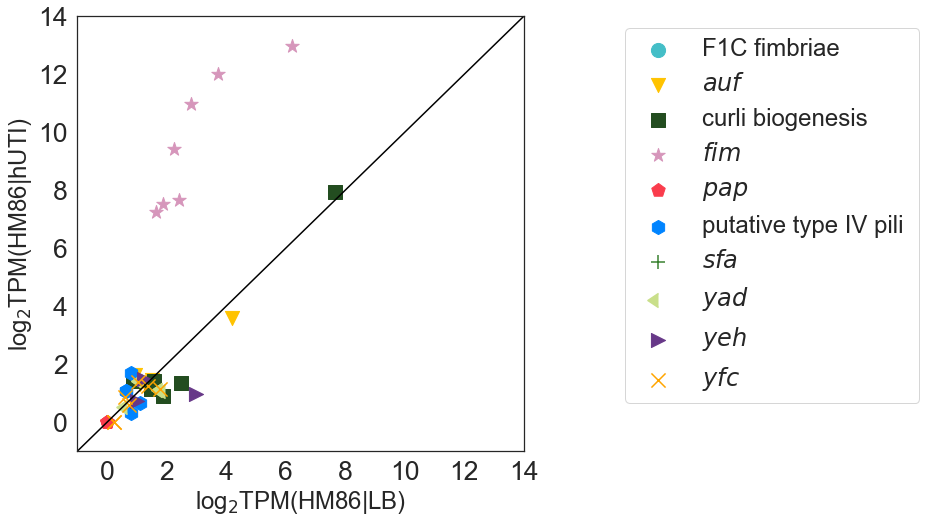

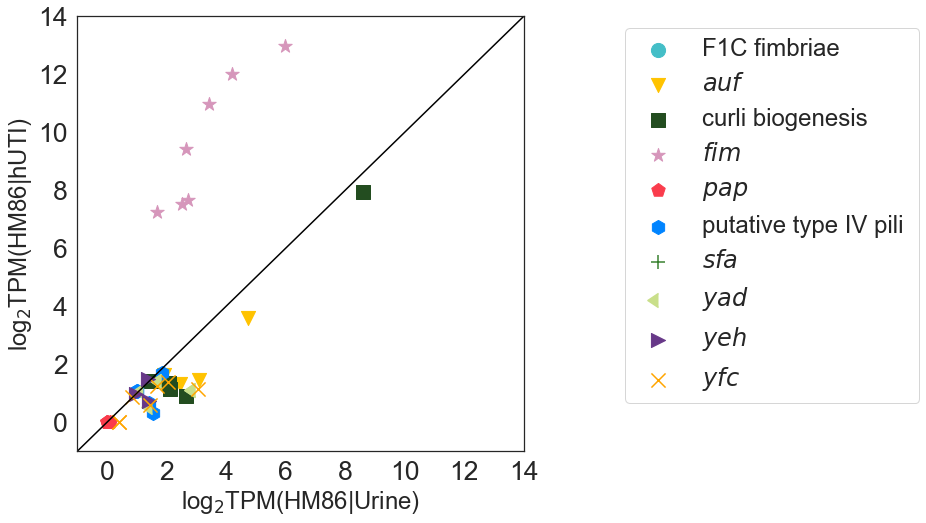

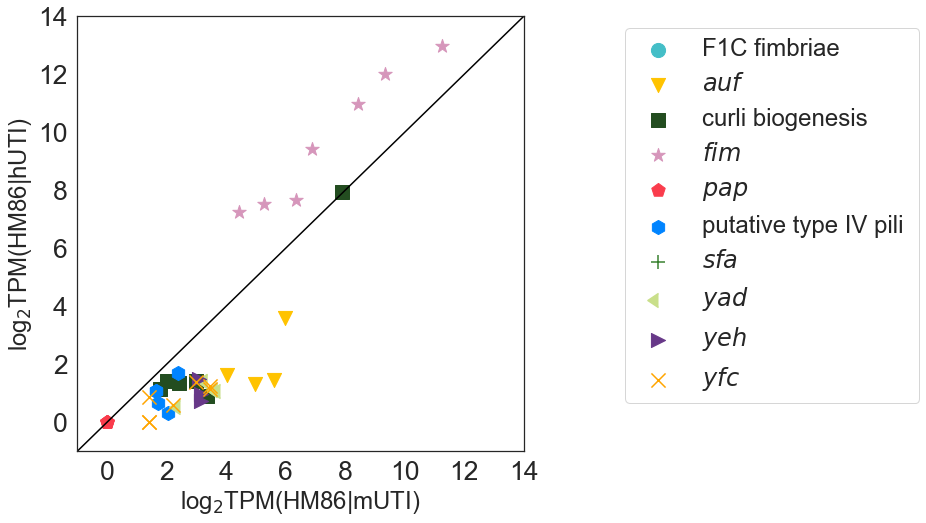

In [112]:
plot_functional_group(df,  group_alias='adherence', conditions=cond3)

In [113]:
mgroups = pd.read_csv("data/metabolism_gene_info.csv", index_col=1) 
met_orth = pd.read_csv("data/2019-06-10_metabolism_orthologs.csv", index_col=0).dropna(how='all')
met_orth.index = [i.split("|")[0] for i in met_orth.index]
met_orth = met_orth[["HM43", "HM56", "HM86"]]
met_cnts = ut.get_tpms_for_prokkas(met_orth, norm_cnts1)
met_cnts = met_cnts.merge(mgroups, left_index=True, right_index=True)
met_cnts.head()

,HM43_UTI,HM43_mouse,HM43_LB,HM43_UR,HM56_UTI,HM56_LB,HM56_UR,HM56_mouse,HM86_LB,HM86_UR,HM86_UTI,HM86_mouse,Genome,Function,Name
b2280,7.634215,8.958626,10.232103,9.618962,7.209909,8.991244,8.981168,8.938481,8.930425,8.479743,7.128449,8.868462,eco,Aerobic Respiration,Sdh
b2288,9.270698,9.968266,10.365832,9.561303,9.104816,10.151435,10.037124,9.485513,9.997590,9.745297,9.705852,9.627848,eco,Aerobic Respiration,Sdh
b1224,4.521132,8.514720,2.098922,3.237265,4.899009,3.434675,2.991230,6.914377,2.223253,2.909277,5.142524,6.001879,eco,Anaerobic Respiration,Nar
b0721,4.982291,5.882744,10.248703,8.545015,2.416368,8.729104,6.860606,5.382074,8.406720,7.079402,4.103650,5.013563,eco,Aerobic Respiration,Sdh
b2283,6.773434,7.930697,8.877717,7.509770,6.236533,7.889173,7.514709,7.273491,7.501694,7.698727,6.451512,7.510985,eco,Aerobic Respiration,Sdh


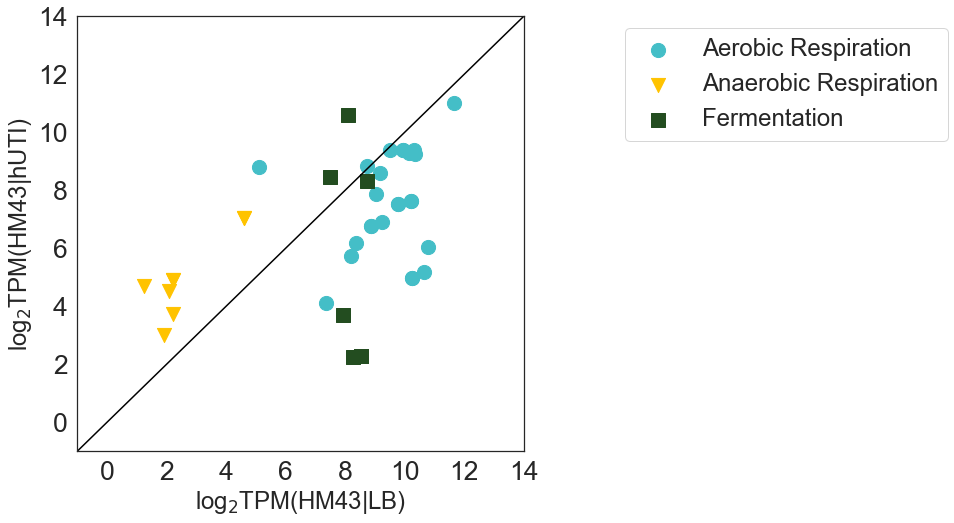

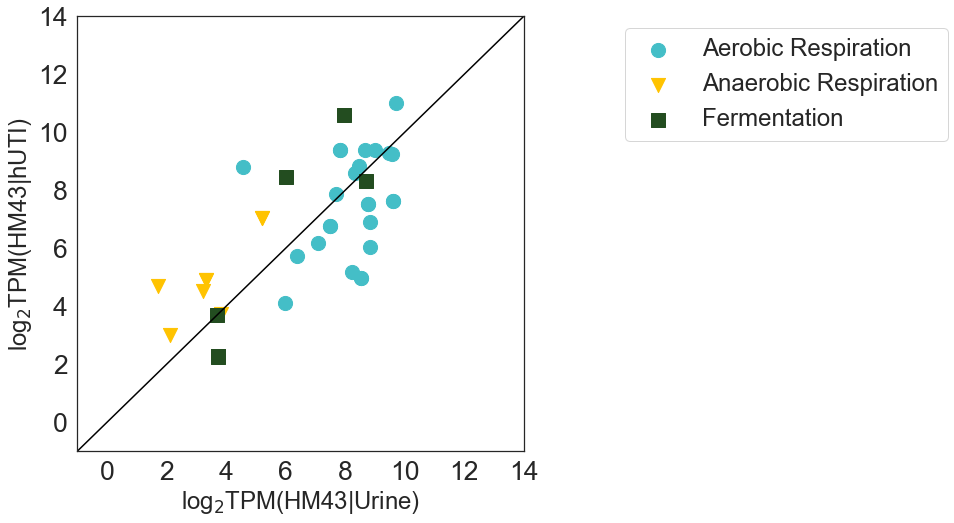

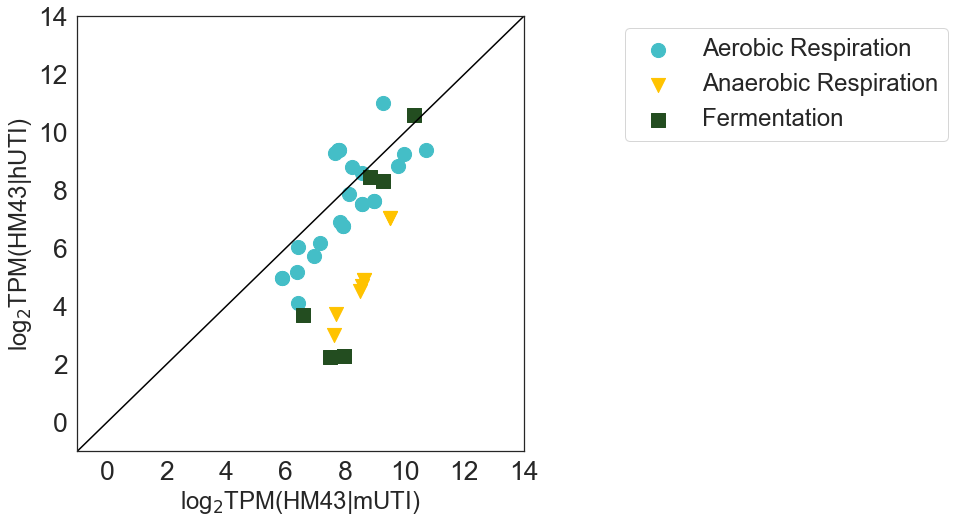

In [114]:
plot_functional_group(met_cnts, groupby="Function", group_alias="metabolism")

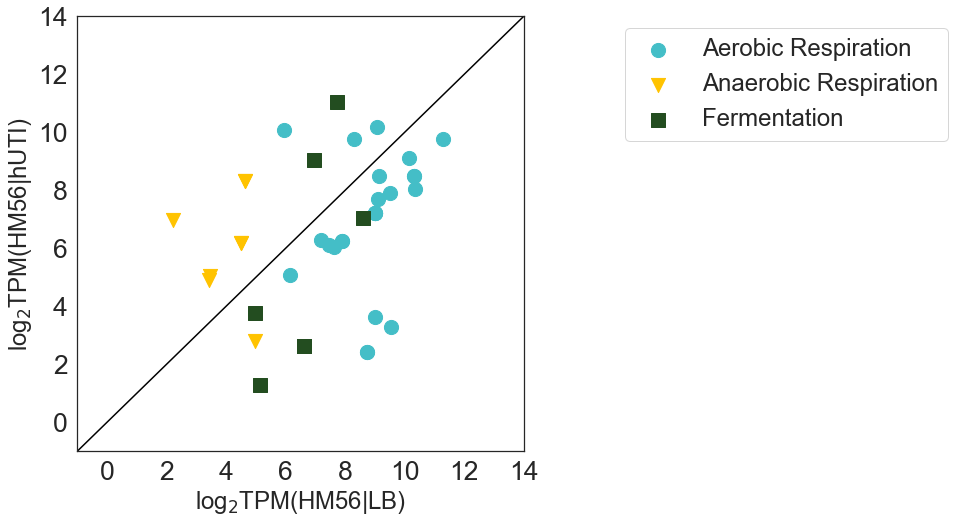

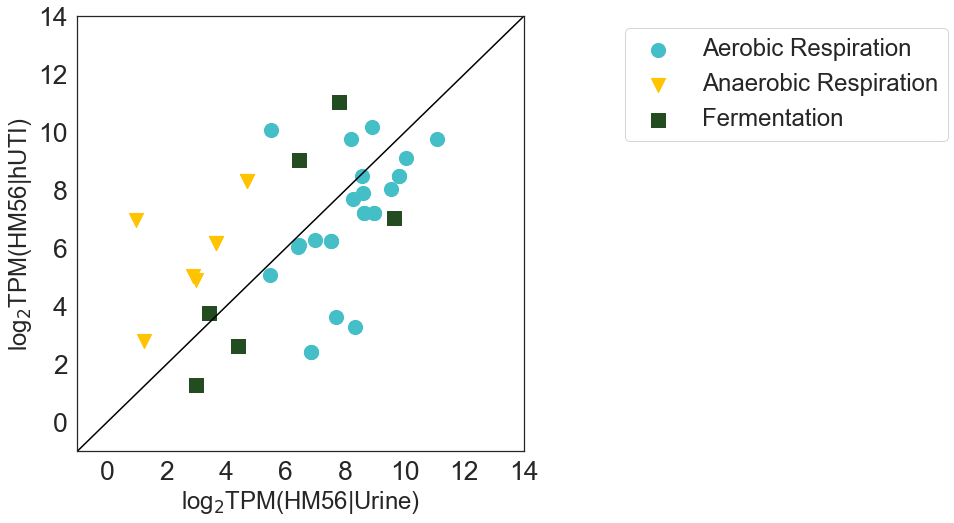

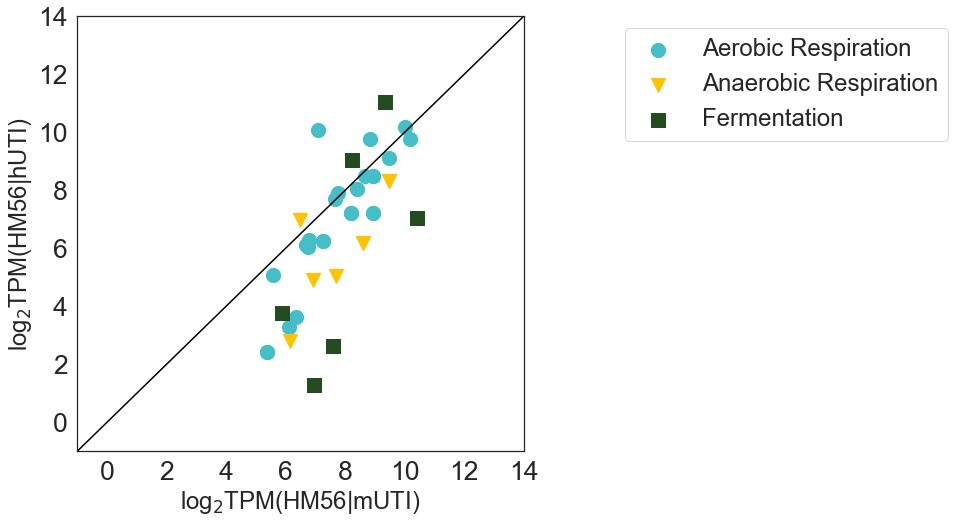

In [115]:
plot_functional_group(met_cnts, groupby="Function", group_alias="metabolism", conditions=cond2)

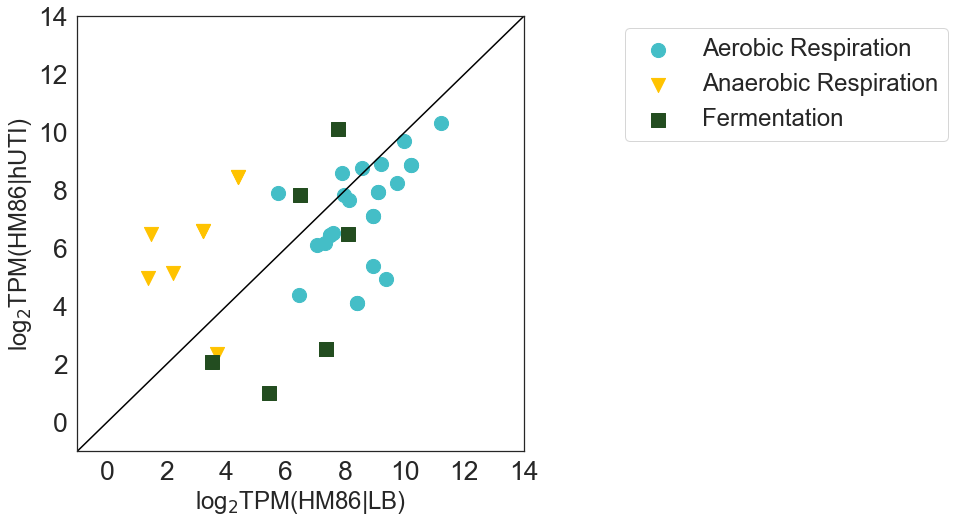

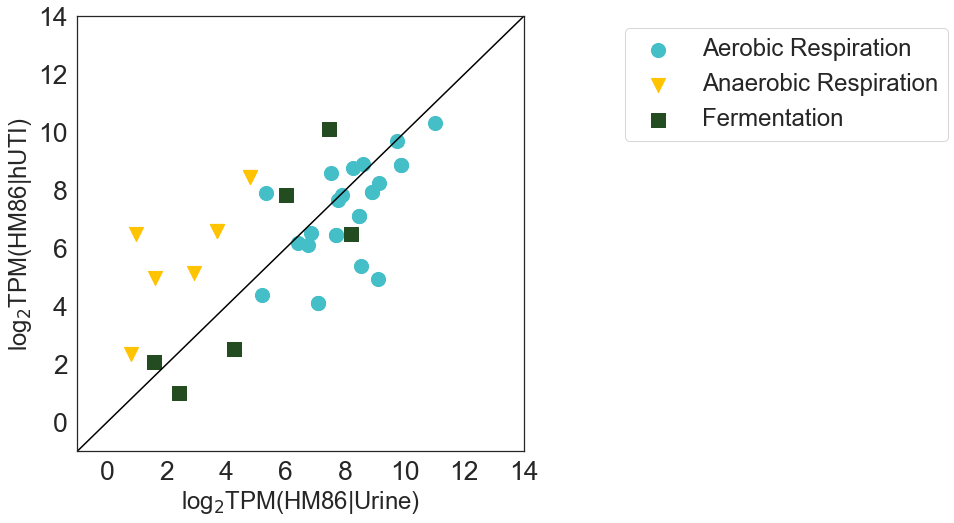

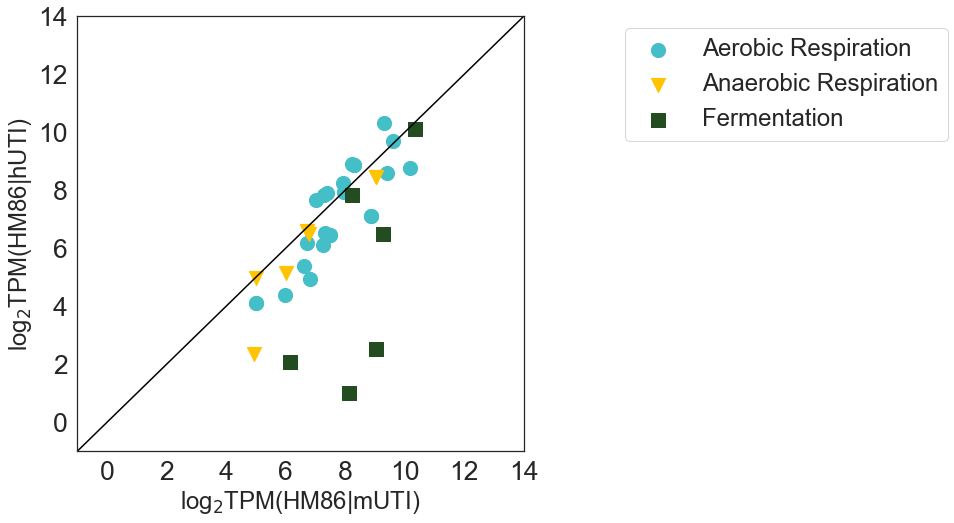

In [116]:
plot_functional_group(met_cnts, groupby="Function", group_alias="metabolism", conditions=cond3)

## Other

In [117]:
if gff_dir.exists():
    tpms = ut.normalize_counts_to_tpm(hm43_counts_dir, gff_dir, results_dir) # HM43 specific
    tpm_43 = pd.DataFrame(tpms)
    tpms = ut.normalize_counts_to_tpm(hm56_counts_dir, gff_dir, results_dir) # HM43 specific
    tpm_56 = pd.DataFrame(tpms)
    tpms = ut.normalize_counts_to_tpm(hm86_counts_dir, gff_dir, results_dir) # HM43 specific
    tpm_86 = pd.DataFrame(tpms)
    tpm_df = pd.concat([tpm_43, tpm_56, tpm_86], axis=1)
    tpm_df.head()


    final_tpms = (ut.get_tpms_for_prokkas(orth_matrix, tpm_df)
                  .dropna(how='all')
                  .merge(orth_matrix[["536", "CFT073", "K-12", "UMN026", "UTI89"]], how='left', left_index=True, right_index=True))
    final_tpms.shape             
    #final_tpms.to_csv(Path(results_dir)/"mouse_uti_tpms.csv")


In [118]:
#...
def get_raw_counts(cnts_dir):
    pd_list = []
    for file in Path(cnts_dir).iterdir():
        if "counts.txt" in str(file):
            df = pd.read_table(file, index_col=0, names=[file.stem.split("_trimmed")[0]])
            pd_list.append(df)
    cnts = pd.concat(pd_list, axis=1)
    return cnts

dir_list = [hm43_counts_dir, hm56_counts_dir, hm86_counts_dir]

rcnts = pd.concat([get_raw_counts(d) for d in dir_list], axis=1, )
rcnts = rcnts.iloc[:-5]

to_drop = ["HM43_LB_rep2", "HM43_UR_rep2"]
rcnts = rcnts.drop(to_drop, axis=1)
rcnts.rename(columns={"HM43_UR_rep1":"HM43_UR", "HM43_LB_rep1":"HM43_LB"},  inplace=True)
frcnts = ut.get_tpms_for_prokkas(orth_matrix, rcnts).dropna()
frcnts.to_csv(results_dir/"counts_for_DE.csv")
#colData.to_csv(results_dir/"info_for_DE.csv")

# At this point running  
#python differential_analysis.py private_results/counts_for_DE.csv private_results/info_for_DE.csv treat_label results/de_analysis/


/Users/annasintsova/miniconda3/envs/bioinf/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]
